In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
import pylab as mplot
import yaml
import h5py
import healpy as hp
import healsparse as hs
import scipy
from scipy import interpolate

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Instructions

Mean shear as a function of X

In [2]:
tag = '0613'
project_dir = '/project/chihway/data/decade/'

# Now start doing mean shear vs. X

In [7]:
def mask_default(cat):
    mask0_default = (~((cat['mcal_T_noshear'][:]>2)*(cat['mcal_s2n_noshear'][:]<30)))*(cat['mcal_T_noshear'][:]<10)*(cat['mcal_s2n_noshear'][:]<1000)*(cat['mcal_s2n_noshear'][:]>10)*(cat['mcal_T_ratio_noshear'][:]>0.5)
    mask_1p_default = (~((cat['mcal_T_1p'][:]>2)*(cat['mcal_s2n_1p'][:]<30)))*(cat['mcal_T_1p'][:]<10)*(cat['mcal_s2n_1p'][:]<1000)*(cat['mcal_s2n_1p'][:]>10)*(cat['mcal_T_ratio_1p'][:]>0.5)
    mask_1m_default = (~((cat['mcal_T_1m'][:]>2)*(cat['mcal_s2n_1m'][:]<30)))*(cat['mcal_T_1m'][:]<10)*(cat['mcal_s2n_1m'][:]<1000)*(cat['mcal_s2n_1m'][:]>10)*(cat['mcal_T_ratio_1m'][:]>0.5)
    mask_2p_default = (~((cat['mcal_T_2p'][:]>2)*(cat['mcal_s2n_2p'][:]<30)))*(cat['mcal_T_2p'][:]<10)*(cat['mcal_s2n_2p'][:]<1000)*(cat['mcal_s2n_2p'][:]>10)*(cat['mcal_T_ratio_2p'][:]>0.5)
    mask_2m_default = (~((cat['mcal_T_2m'][:]>2)*(cat['mcal_s2n_2m'][:]<30)))*(cat['mcal_T_2m'][:]<10)*(cat['mcal_s2n_2m'][:]<1000)*(cat['mcal_s2n_2m'][:]>10)*(cat['mcal_T_ratio_2m'][:]>0.5)

    return mask0_default, mask_1p_default, mask_1m_default, mask_2p_default, mask_2m_default


In [8]:
def get_Rs(cat, m0, m_1p, m_1m, m_2p, m_2m):
    
    # calcualte metacalibration factors
    dgamma = 2*0.01
    
    R11  = (np.mean(cat['mcal_g_1p'][:,0][m0]) - np.mean(cat['mcal_g_1m'][:,0][m0]))/dgamma
    R11s = (np.mean(cat['mcal_g_noshear'][:,0][m_1p]) - np.mean(cat['mcal_g_noshear'][:,0][m_1m]))/dgamma
    R11tot = R11 + R11s

    R22  = (np.mean(cat['mcal_g_2p'][:,1][m0]) - np.mean(cat['mcal_g_2m'][:,1][m0]))/dgamma
    R22s = (np.mean(cat['mcal_g_noshear'][:,1][m_2p]) - np.mean(cat['mcal_g_noshear'][:,1][m_2m]))/dgamma
    R22tot = R22 + R22s
    
    return R11tot, R22tot
    

In [9]:
def calibrate_bin_X(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1p = df_1p*(cat[tag+'_1p'][:]>lim1)*(cat[tag+'_1p'][:]<=lim2)
    mask_1m = df_1m*(cat[tag+'_1m'][:]>lim1)*(cat[tag+'_1m'][:]<=lim2)
    mask_2p = df_2p*(cat[tag+'_2p'][:]>lim1)*(cat[tag+'_2p'][:]<=lim2)
    mask_2m = df_2m*(cat[tag+'_2m'][:]>lim1)*(cat[tag+'_2m'][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)


In [10]:
def calibrate_bin_Y(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1p = df_1p*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_1m = df_1m*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_2p = df_2p*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    mask_2m = df_2m*(cat[tag+'_noshear'][:]>lim1)*(cat[tag+'_noshear'][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)


In [11]:
def calibrate_bin_Z(cat, tag, n, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_1p = df_1p*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_1m = df_1m*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_2p = df_2p*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    mask_2m = df_2m*(cat[tag+'_noshear'][:,n]>lim1)*(cat[tag+'_noshear'][:,n]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)


In [26]:
def calibrate_bin_A(cat, tag, lim1, lim2):
    
    df0, df_1p, df_1m, df_2p, df_2m = mask_default(cat)
    
    mask0 = df0*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_1p = df_1p*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_1m = df_1m*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_2p = df_2p*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    mask_2m = df_2m*(cat[tag][:]>lim1)*(cat[tag][:]<=lim2)
    
    R11tot, R22tot = get_Rs(cat, mask0, mask_1p, mask_1m, mask_2p, mask_2m)
    
    e1 = cat['mcal_g_noshear'][:,0][mask0]/R11tot
    e2 = cat['mcal_g_noshear'][:,1][mask0]/R22tot

    return np.mean(e1), np.mean(e2),np.std(e1)/np.sqrt(len(e1)), np.std(e2)/np.sqrt(len(e2)),len(e1), len(e2)


### Mean shear vs. SNR

In [20]:
with h5py.File('/project2/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf', 'r') as h5r:
    new = h5r['DATA']
    XX = []
    SNR = []
    for i in range(20):
        snr1 = 10**(1+i*0.1)
        snr2 = 10**(1+i*0.1+0.1)
        X = calibrate_bin_X(new, 'mcal_s2n', snr1, snr2)
        XX.append(X)
        SNR.append(10**(1+i*0.1+0.05))
    XX = np.array(XX)

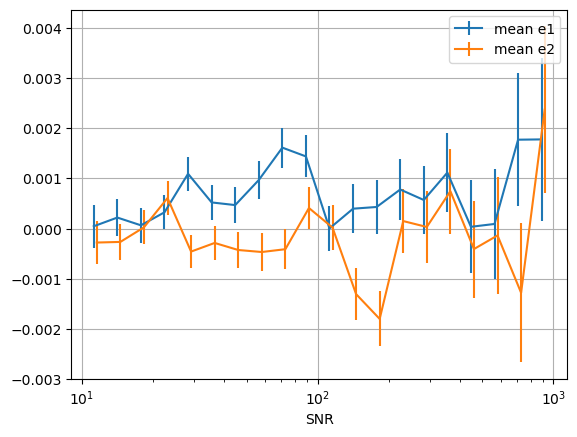

In [21]:
SNR = np.array(SNR)
mplot.errorbar(SNR, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(SNR*1.03, XX[:,1], XX[:,3], label='mean e2')

mplot.xscale('log')
mplot.xlabel('SNR')
mplot.legend()
mplot.grid()

### Mean shear vs. size ratio

In [23]:
with h5py.File('/project2/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf', 'r') as h5r:
    new = h5r['DATA']
    XX = []
    Size = []
    for i in range(15):
        size1 = 0.5+0.2*i
        size2 = 0.5+0.2*i+0.2
        X = calibrate_bin_X(new, 'mcal_T_ratio', size1, size2)
        XX.append(X)
        Size.append(0.5+0.2*i+0.1)
    XX = np.array(XX)

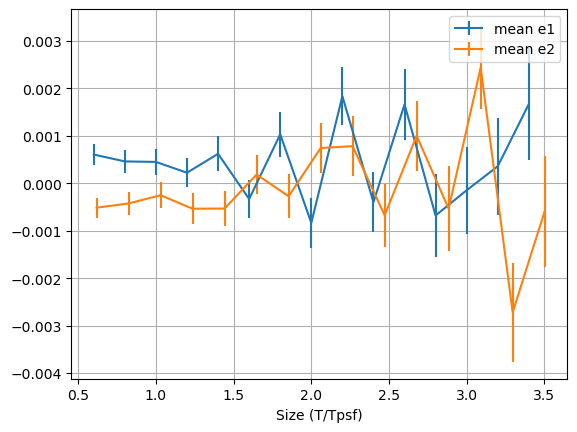

In [25]:
Size = np.array(Size)
mplot.errorbar(Size, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(Size*1.03, XX[:,1], XX[:,3], label='mean e2')

mplot.xlabel('Size (T/Tpsf)')
mplot.legend()
mplot.grid()

### Mean shear vs. PSF size

In [26]:
with h5py.File('/project2/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf', 'r') as h5r:
    new = h5r['DATA']
    XX = []
    Size = []
    for i in range(10):
        size1 = 0.3+0.04*i
        size2 = 0.3+0.04*i+0.04
        X = calibrate_bin_Y(new, 'mcal_psf_T', size1, size2)
        XX.append(X)
        Size.append(0.3+0.04*i+0.02)
    XX = np.array(XX)

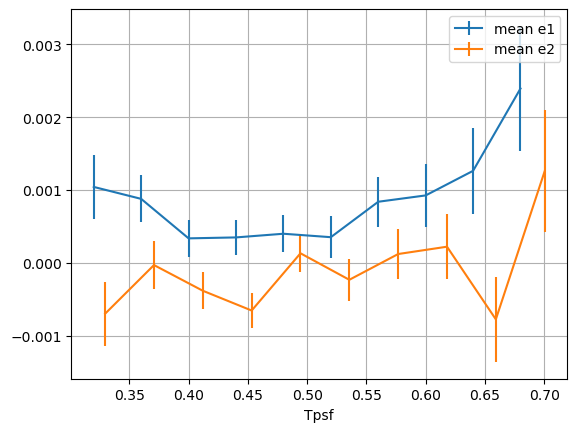

In [27]:
Size = np.array(Size)
mplot.errorbar(Size, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(Size*1.03, XX[:,1], XX[:,3], label='mean e2')

mplot.xlabel('Tpsf')
mplot.legend()
mplot.grid()

### PSF e1, e2

In [24]:
XX = []
E1 = []
for i in range(20):
    ee1 = -0.1+0.01*i
    ee2 = -0.1+0.01*i+0.01
    X = calibrate_bin_Z(new, 'mcal_psf_g', 0, ee1, ee2)
    XX.append(X)
    E1.append(-0.1+0.01*i+0.005)
XX = np.array(XX)

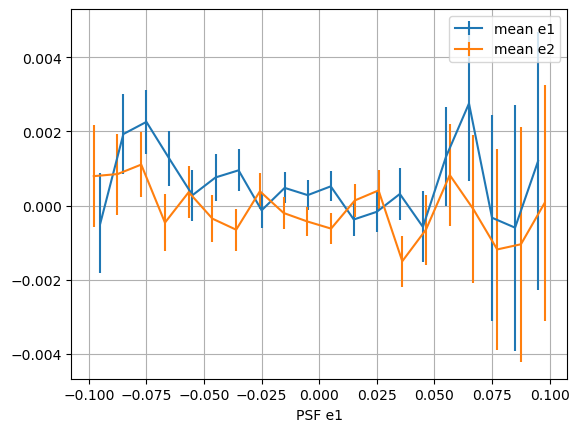

In [25]:
E1 = np.array(E1)
mplot.errorbar(E1, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(E1*1.03, XX[:,1], XX[:,3], label='mean e2')

mplot.xlabel('PSF e1')
mplot.legend()
mplot.grid()

In [26]:
XX = []
E2 = []
for i in range(20):
    ee1 = -0.1+0.01*i
    ee2 = -0.1+0.01*i+0.01
    X = calibrate_bin_Z(new, 'mcal_psf_g', 1, ee1, ee2)
    XX.append(X)
    E2.append(-0.1+0.01*i+0.005)
XX = np.array(XX)

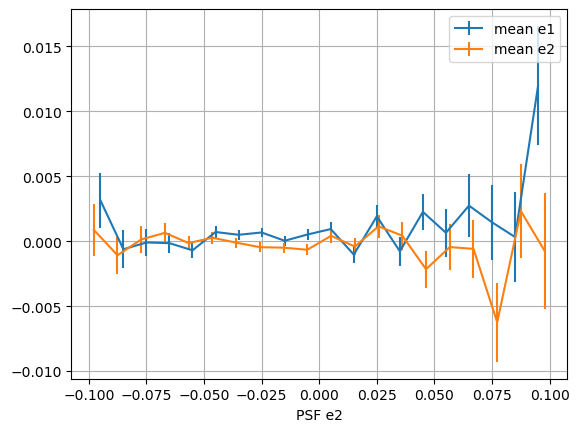

In [27]:
E2 = np.array(E2)
mplot.errorbar(E2, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(E2*1.03, XX[:,1], XX[:,3], label='mean e2')

mplot.xlabel('PSF e2')
mplot.legend()
mplot.grid()

### Mean PSF ellipticity vs. Dec

In [23]:
with h5py.File('/project/kicp/chihway/metacal_test_1000tiles_20221108_all.hdf', 'r') as h5r:
    new = h5r['DATA']
    
    XX = []
    YY = []
    eXX = []
    eYY = []
    DEC = []
    for i in range(20):
        ee1 = -30+3*i
        ee2 = -30+3*i+3
        df0, df_1p, df_1m, df_2p, df_2m = mask_default(new)

        mask0 = df0*(new['dec'][:]>ee1)*(new['dec'][:]<=ee2)
        psf_e1 = new['mcal_psf_g_noshear'][:,0][mask0]
        psf_e2 = new['mcal_psf_g_noshear'][:,1][mask0]

        XX.append(np.mean(psf_e1))
        YY.append(np.mean(psf_e2))
        eXX.append(np.std(psf_e1))
        eYY.append(np.std(psf_e2))

        DEC.append(-30+3*i+1.5)
    XX = np.array(XX)
    YY = np.array(YY)
    eXX = np.array(eXX)/len(XX)**0.5
    eYY = np.array(eYY)/len(YY)**0.5

    DEC = np.array(DEC)


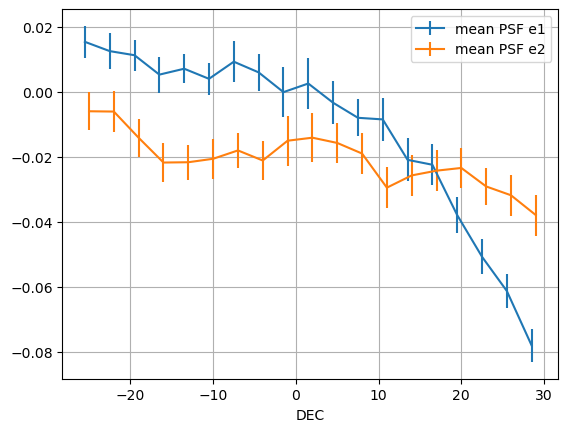

In [25]:
mplot.errorbar(DEC, XX, eXX, label='mean PSF e1')
mplot.errorbar(DEC+0.5, YY, eYY, label='mean PSF e2')

mplot.xlabel('DEC')
mplot.legend()
mplot.grid()

### Mean shear vs. DEC

In [27]:
with h5py.File('/project/kicp/chihway/metacal_test_1000tiles_20221108_all.hdf', 'r') as h5r:
    new = h5r['DATA']
    XX = []
    DEC = []
    for i in range(20):
        dec1 = -30+3*i
        dec2 = -30+3*i+3
        X = calibrate_bin_A(new, 'dec', dec1, dec2)
        XX.append(X)
        DEC.append(-30+3*i+1.5)
    XX = np.array(XX)

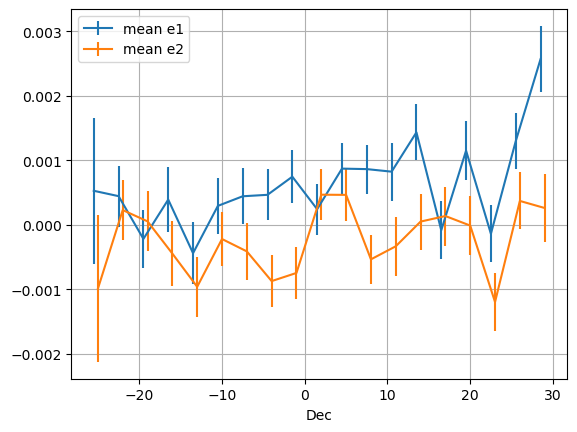

In [28]:
DEC = np.array(DEC)
mplot.errorbar(DEC, XX[:,0], XX[:,2], label='mean e1')
mplot.errorbar(DEC+0.5, XX[:,1], XX[:,3], label='mean e2')

mplot.xlabel('Dec')
mplot.legend()
mplot.grid()